In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=32, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         5152      
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_20 (Activation)   (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3735 - acc: 0.2478
Epoch 00001: val_loss improved from inf to 2.01200, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_3_conv_checkpoint/001-2.0120.hdf5
36805/36805 [==============================] - 24s 654us/sample - loss: 2.3734 - acc: 0.2479 - val_loss: 2.0120 - val_acc: 0.3753
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8500 - acc: 0.4309
Epoch 00002: val_loss improved from 2.01200 to 1.76180, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_3_conv_checkpoint/002-1.7618.hdf5
36805/36805 [==============================] - 23s 614us/sample - loss: 1.8501 - acc: 0.4309 - val_loss: 1.7618 - val_acc: 0.4454
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5935 - acc: 0.5117
Epoch 00003: val_loss improved from 1.76180 to 1.60145, saving mode

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4492 - acc: 0.8572
Epoch 00027: val_loss did not improve from 1.44930
36805/36805 [==============================] - 23s 618us/sample - loss: 0.4493 - acc: 0.8572 - val_loss: 1.6700 - val_acc: 0.5756
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4374 - acc: 0.8604
Epoch 00028: val_loss did not improve from 1.44930
36805/36805 [==============================] - 23s 613us/sample - loss: 0.4373 - acc: 0.8604 - val_loss: 1.6849 - val_acc: 0.5765
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4199 - acc: 0.8669
Epoch 00029: val_loss did not improve from 1.44930
36805/36805 [==============================] - 23s 617us/sample - loss: 0.4199 - acc: 0.8669 - val_loss: 1.7049 - val_acc: 0.5751
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4009 - acc: 0.8705
Epoch 00030: val_loss did not improve from 1.44930
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2072 - acc: 0.9355
Epoch 00057: val_loss did not improve from 1.44930
36805/36805 [==============================] - 23s 615us/sample - loss: 0.2072 - acc: 0.9355 - val_loss: 2.0605 - val_acc: 0.5947
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2005 - acc: 0.9381
Epoch 00058: val_loss did not improve from 1.44930
36805/36805 [==============================] - 23s 617us/sample - loss: 0.2007 - acc: 0.9381 - val_loss: 2.0634 - val_acc: 0.5961

1D_CNN_custom_ch_32_DO_3_conv Model


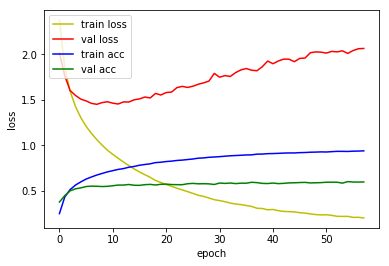

4815/4815 [==============================] - 2s 323us/sample - loss: 1.5276 - acc: 0.5169
Loss: 1.5275790819126498 Accuracy: 0.5169263

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3194 - acc: 0.2541
Epoch 00001: val_loss improved from inf to 1.82589, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_4_conv_checkpoint/001-1.8259.hdf5
36805/36805 [==============================] - 24s 655us/sample - loss: 2.3193 - acc: 0.2541 - val_loss: 1.8259 - val_acc: 0.4228
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7313 - acc: 0.4477
Epoch 00002: val_loss improved from 1.82589 to 1.61547, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_4_conv_checkpoint/002-1.6155.hdf5
36805/36805 [==============================] - 23s 629us/sample - loss: 1.7312 - acc: 0.4477 - val_loss: 1.6155 - val_acc: 0.4885
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6104 - acc: 0.8090
Epoch 00025: val_loss did not improve from 1.04501
36805/36805 [==============================] - 23s 630us/sample - loss: 0.6104 - acc: 0.8090 - val_loss: 1.0478 - val_acc: 0.6942
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5846 - acc: 0.8160
Epoch 00026: val_loss improved from 1.04501 to 1.03054, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_4_conv_checkpoint/026-1.0305.hdf5
36805/36805 [==============================] - 23s 630us/sample - loss: 0.5845 - acc: 0.8160 - val_loss: 1.0305 - val_acc: 0.7028
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5650 - acc: 0.8222
Epoch 00027: val_loss improved from 1.03054 to 1.02962, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_4_conv_checkpoint/027-1.0296.hdf5
36805/36805 [==============================] - 23s 632us/sample - loss: 0.5649 - acc: 0.8223 - val_loss: 1

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3059 - acc: 0.9007
Epoch 00054: val_loss did not improve from 1.02962
36805/36805 [==============================] - 23s 631us/sample - loss: 0.3059 - acc: 0.9007 - val_loss: 1.1377 - val_acc: 0.7212
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2989 - acc: 0.9010
Epoch 00055: val_loss did not improve from 1.02962
36805/36805 [==============================] - 23s 631us/sample - loss: 0.2990 - acc: 0.9010 - val_loss: 1.1552 - val_acc: 0.7195
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2953 - acc: 0.9022
Epoch 00056: val_loss did not improve from 1.02962
36805/36805 [==============================] - 23s 633us/sample - loss: 0.2953 - acc: 0.9022 - val_loss: 1.1468 - val_acc: 0.7212
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.9037
Epoch 00057: val_loss did not improve from 1.02962
36805/36805 [=====

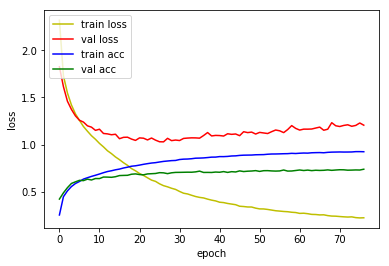

4815/4815 [==============================] - 2s 335us/sample - loss: 1.1507 - acc: 0.6656
Loss: 1.150674240363845 Accuracy: 0.66562825

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3854 - acc: 0.2131
Epoch 00001: val_loss improved from inf to 1.80858, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_5_conv_checkpoint/001-1.8086.hdf5
36805/36805 [==============================] - 26s 698us/sample - loss: 2.3853 - acc: 0.2131 - val_loss: 1.8086 - val_acc: 0.4172
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7117 - acc: 0.4407
Epoch 00002: val_loss improved from 1.80858 to 1.50537, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_5_conv_checkpoint/002-1.5054.hdf5
36805/36805 [==============================] - 24s 659us/sample - loss: 1.7117 - acc: 0.4407 - val_loss: 1.5054 - val_acc: 0.5227
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5636 - acc: 0.8286
Epoch 00024: val_loss improved from 0.77646 to 0.76112, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_5_conv_checkpoint/024-0.7611.hdf5
36805/36805 [==============================] - 24s 663us/sample - loss: 0.5637 - acc: 0.8286 - val_loss: 0.7611 - val_acc: 0.7764
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5509 - acc: 0.8321
Epoch 00025: val_loss did not improve from 0.76112
36805/36805 [==============================] - 24s 659us/sample - loss: 0.5508 - acc: 0.8321 - val_loss: 0.7778 - val_acc: 0.7799
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5346 - acc: 0.8364
Epoch 00026: val_loss improved from 0.76112 to 0.74828, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_5_conv_checkpoint/026-0.7483.hdf5
36805/36805 [==============================] - 24s 662us/sample - loss: 0.5345 - acc: 0.8364 - val_loss: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.2884 - acc: 0.9056
Epoch 00052: val_loss did not improve from 0.72818
36805/36805 [==============================] - 25s 669us/sample - loss: 0.2884 - acc: 0.9056 - val_loss: 0.7608 - val_acc: 0.7934
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2820 - acc: 0.9086
Epoch 00053: val_loss did not improve from 0.72818
36805/36805 [==============================] - 24s 664us/sample - loss: 0.2819 - acc: 0.9086 - val_loss: 0.7828 - val_acc: 0.7955
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2748 - acc: 0.9114
Epoch 00054: val_loss did not improve from 0.72818
36805/36805 [==============================] - 25s 667us/sample - loss: 0.2748 - acc: 0.9114 - val_loss: 0.7594 - val_acc: 0.8039
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2715 - acc: 0.9118
Epoch 00055: val_loss did not improve from 0.72818
36805/36805 [==================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9364
Epoch 00082: val_loss did not improve from 0.72818
36805/36805 [==============================] - 24s 657us/sample - loss: 0.1941 - acc: 0.9363 - val_loss: 0.8059 - val_acc: 0.8106
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1890 - acc: 0.9362
Epoch 00083: val_loss did not improve from 0.72818
36805/36805 [==============================] - 24s 659us/sample - loss: 0.1890 - acc: 0.9362 - val_loss: 0.8167 - val_acc: 0.8164

1D_CNN_custom_ch_32_DO_5_conv Model


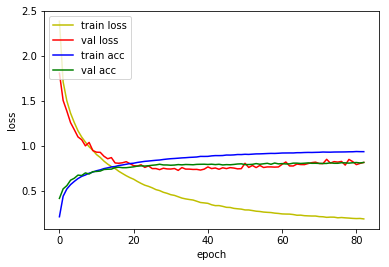

4815/4815 [==============================] - 2s 329us/sample - loss: 0.8196 - acc: 0.7605
Loss: 0.8195533891457016 Accuracy: 0.76054

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4982 - acc: 0.1763
Epoch 00001: val_loss improved from inf to 1.92088, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_6_conv_checkpoint/001-1.9209.hdf5
36805/36805 [==============================] - 27s 736us/sample - loss: 2.4982 - acc: 0.1763 - val_loss: 1.9209 - val_acc: 0.3760
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7969 - acc: 0.4131
Epoch 00002: val_loss improved from 1.92088 to 1.55590, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_6_conv_checkpoint/002-1.5559.hdf5
36805/36805 [==============================] - 25s 676us/sample - loss: 1.7968 - acc: 0.4131 - val_loss: 1.5559 - val_acc: 0.5066
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

36800/36805 [============================>.] - ETA: 0s - loss: 0.6276 - acc: 0.8096
Epoch 00023: val_loss did not improve from 0.59966
36805/36805 [==============================] - 25s 673us/sample - loss: 0.6276 - acc: 0.8096 - val_loss: 0.6061 - val_acc: 0.8253
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6091 - acc: 0.8131
Epoch 00024: val_loss improved from 0.59966 to 0.57283, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_6_conv_checkpoint/024-0.5728.hdf5
36805/36805 [==============================] - 25s 673us/sample - loss: 0.6090 - acc: 0.8132 - val_loss: 0.5728 - val_acc: 0.8390
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5935 - acc: 0.8223
Epoch 00025: val_loss did not improve from 0.57283
36805/36805 [==============================] - 25s 670us/sample - loss: 0.5935 - acc: 0.8223 - val_loss: 0.5785 - val_acc: 0.8332
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5823 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.3769 - acc: 0.8844
Epoch 00047: val_loss did not improve from 0.42838
36805/36805 [==============================] - 25s 677us/sample - loss: 0.3770 - acc: 0.8844 - val_loss: 0.4377 - val_acc: 0.8805
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3759 - acc: 0.8851
Epoch 00048: val_loss did not improve from 0.42838
36805/36805 [==============================] - 25s 679us/sample - loss: 0.3760 - acc: 0.8851 - val_loss: 0.4316 - val_acc: 0.8842
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3747 - acc: 0.8845
Epoch 00049: val_loss did not improve from 0.42838
36805/36805 [==============================] - 25s 690us/sample - loss: 0.3747 - acc: 0.8845 - val_loss: 0.4445 - val_acc: 0.8761
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3576 - acc: 0.8913
Epoch 00050: val_loss did not improve from 0.42838
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2597 - acc: 0.9165
Epoch 00074: val_loss did not improve from 0.37927
36805/36805 [==============================] - 25s 672us/sample - loss: 0.2597 - acc: 0.9165 - val_loss: 0.3824 - val_acc: 0.9036
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2643 - acc: 0.9161
Epoch 00075: val_loss did not improve from 0.37927
36805/36805 [==============================] - 25s 679us/sample - loss: 0.2643 - acc: 0.9161 - val_loss: 0.3922 - val_acc: 0.8994
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2566 - acc: 0.9187
Epoch 00076: val_loss did not improve from 0.37927
36805/36805 [==============================] - 25s 675us/sample - loss: 0.2567 - acc: 0.9187 - val_loss: 0.4135 - val_acc: 0.8947
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2571 - acc: 0.9177
Epoch 00077: val_loss did not improve from 0.37927
36805/36805 [==================

Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1932 - acc: 0.9357
Epoch 00103: val_loss did not improve from 0.36884
36805/36805 [==============================] - 25s 671us/sample - loss: 0.1932 - acc: 0.9357 - val_loss: 0.3702 - val_acc: 0.9106
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1937 - acc: 0.9361
Epoch 00104: val_loss did not improve from 0.36884
36805/36805 [==============================] - 25s 674us/sample - loss: 0.1938 - acc: 0.9361 - val_loss: 0.3793 - val_acc: 0.9045
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1944 - acc: 0.9367
Epoch 00105: val_loss did not improve from 0.36884
36805/36805 [==============================] - 25s 671us/sample - loss: 0.1945 - acc: 0.9367 - val_loss: 0.3843 - val_acc: 0.9099
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1952 - acc: 0.9361
Epoch 00106: val_loss did not improve from 0.36884
36805/36805 [=

Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1572 - acc: 0.9482
Epoch 00132: val_loss did not improve from 0.36709
36805/36805 [==============================] - 25s 674us/sample - loss: 0.1572 - acc: 0.9482 - val_loss: 0.3851 - val_acc: 0.9150
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1578 - acc: 0.9476
Epoch 00133: val_loss did not improve from 0.36709
36805/36805 [==============================] - 25s 682us/sample - loss: 0.1578 - acc: 0.9476 - val_loss: 0.3912 - val_acc: 0.9106
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9457
Epoch 00134: val_loss did not improve from 0.36709
36805/36805 [==============================] - 25s 690us/sample - loss: 0.1598 - acc: 0.9457 - val_loss: 0.3834 - val_acc: 0.9140
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1540 - acc: 0.9494
Epoch 00135: val_loss did not improve from 0.36709
36805/36805 [=

Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1361 - acc: 0.9541
Epoch 00162: val_loss did not improve from 0.36709
36805/36805 [==============================] - 25s 681us/sample - loss: 0.1360 - acc: 0.9541 - val_loss: 0.3691 - val_acc: 0.9171
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1345 - acc: 0.9562
Epoch 00163: val_loss did not improve from 0.36709
36805/36805 [==============================] - 25s 687us/sample - loss: 0.1344 - acc: 0.9562 - val_loss: 0.3825 - val_acc: 0.9196
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1318 - acc: 0.9557
Epoch 00164: val_loss did not improve from 0.36709
36805/36805 [==============================] - 25s 681us/sample - loss: 0.1318 - acc: 0.9557 - val_loss: 0.3897 - val_acc: 0.9173
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.9590
Epoch 00165: val_loss did not improve from 0.36709
36805/36805 [=

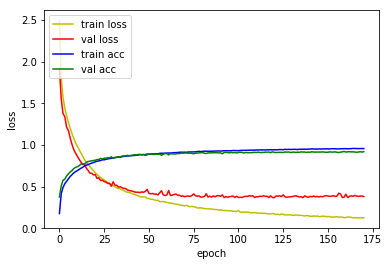

4815/4815 [==============================] - 2s 348us/sample - loss: 0.4329 - acc: 0.8893
Loss: 0.4329061113166413 Accuracy: 0.8893043

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5627 - acc: 0.1510
Epoch 00001: val_loss improved from inf to 2.01433, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_7_conv_checkpoint/001-2.0143.hdf5
36805/36805 [==============================] - 28s 754us/sample - loss: 2.5627 - acc: 0.1510 - val_loss: 2.0143 - val_acc: 0.3364
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8914 - acc: 0.3705
Epoch 00002: val_loss improved from 2.01433 to 1.52395, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_7_conv_checkpoint/002-1.5239.hdf5
36805/36805 [==============================] - 25s 688us/sample - loss: 1.8914 - acc: 0.3705 - val_loss: 1.5239 - val_acc: 0.5178
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4916 - acc: 0.8499
Epoch 00023: val_loss improved from 0.40320 to 0.38296, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_7_conv_checkpoint/023-0.3830.hdf5
36805/36805 [==============================] - 26s 693us/sample - loss: 0.4919 - acc: 0.8498 - val_loss: 0.3830 - val_acc: 0.8942
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4788 - acc: 0.8528
Epoch 00024: val_loss improved from 0.38296 to 0.36440, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_7_conv_checkpoint/024-0.3644.hdf5
36805/36805 [==============================] - 25s 685us/sample - loss: 0.4788 - acc: 0.8528 - val_loss: 0.3644 - val_acc: 0.8984
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4585 - acc: 0.8579
Epoch 00025: val_loss did not improve from 0.36440
36805/36805 [==============================] - 25s 682us/sample - loss: 0.4585 - acc: 0.8579 - val_loss: 0.3737 - val_a

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2801 - acc: 0.9106
Epoch 00049: val_loss did not improve from 0.23944
36805/36805 [==============================] - 25s 676us/sample - loss: 0.2801 - acc: 0.9106 - val_loss: 0.2418 - val_acc: 0.9306
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2788 - acc: 0.9120
Epoch 00050: val_loss improved from 0.23944 to 0.23385, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_7_conv_checkpoint/050-0.2338.hdf5
36805/36805 [==============================] - 25s 690us/sample - loss: 0.2790 - acc: 0.9120 - val_loss: 0.2338 - val_acc: 0.9324
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2745 - acc: 0.9146
Epoch 00051: val_loss did not improve from 0.23385
36805/36805 [==============================] - 26s 694us/sample - loss: 0.2745 - acc: 0.9147 - val_loss: 0.2506 - val_acc: 0.9299
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 76/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2065 - acc: 0.9325
Epoch 00076: val_loss did not improve from 0.20772
36805/36805 [==============================] - 26s 699us/sample - loss: 0.2065 - acc: 0.9325 - val_loss: 0.2315 - val_acc: 0.9383
Epoch 77/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2023 - acc: 0.9346
Epoch 00077: val_loss did not improve from 0.20772
36805/36805 [==============================] - 26s 706us/sample - loss: 0.2022 - acc: 0.9346 - val_loss: 0.2162 - val_acc: 0.9394
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1999 - acc: 0.9349
Epoch 00078: val_loss did not improve from 0.20772
36805/36805 [==============================] - 26s 695us/sample - loss: 0.1998 - acc: 0.9350 - val_loss: 0.2113 - val_acc: 0.9420
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2015 - acc: 0.9350
Epoch 00079: val_loss did not improve from 0.20772
36805/36805 [=====

Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1630 - acc: 0.9459
Epoch 00105: val_loss did not improve from 0.19551
36805/36805 [==============================] - 25s 686us/sample - loss: 0.1630 - acc: 0.9459 - val_loss: 0.2151 - val_acc: 0.9439
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1614 - acc: 0.9471
Epoch 00106: val_loss did not improve from 0.19551
36805/36805 [==============================] - 25s 689us/sample - loss: 0.1614 - acc: 0.9471 - val_loss: 0.2079 - val_acc: 0.9427
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1584 - acc: 0.9468
Epoch 00107: val_loss did not improve from 0.19551
36805/36805 [==============================] - 25s 691us/sample - loss: 0.1584 - acc: 0.9468 - val_loss: 0.2131 - val_acc: 0.9404
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1617 - acc: 0.9450
Epoch 00108: val_loss did not improve from 0.19551
36805/36805 [=

Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1312 - acc: 0.9554
Epoch 00134: val_loss did not improve from 0.19354
36805/36805 [==============================] - 25s 687us/sample - loss: 0.1312 - acc: 0.9554 - val_loss: 0.2001 - val_acc: 0.9471
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1348 - acc: 0.9548
Epoch 00135: val_loss did not improve from 0.19354
36805/36805 [==============================] - 25s 689us/sample - loss: 0.1348 - acc: 0.9548 - val_loss: 0.2001 - val_acc: 0.9476
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1356 - acc: 0.9530
Epoch 00136: val_loss did not improve from 0.19354
36805/36805 [==============================] - 25s 689us/sample - loss: 0.1356 - acc: 0.9530 - val_loss: 0.2340 - val_acc: 0.9418
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1326 - acc: 0.9555
Epoch 00137: val_loss did not improve from 0.19354
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.1137 - acc: 0.9606
Epoch 00163: val_loss did not improve from 0.19160
36805/36805 [==============================] - 25s 687us/sample - loss: 0.1137 - acc: 0.9606 - val_loss: 0.1964 - val_acc: 0.9504
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9616
Epoch 00164: val_loss did not improve from 0.19160
36805/36805 [==============================] - 25s 690us/sample - loss: 0.1121 - acc: 0.9616 - val_loss: 0.1958 - val_acc: 0.9513
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1144 - acc: 0.9610
Epoch 00165: val_loss did not improve from 0.19160
36805/36805 [==============================] - 25s 689us/sample - loss: 0.1145 - acc: 0.9610 - val_loss: 0.2110 - val_acc: 0.9457
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1102 - acc: 0.9617
Epoch 00166: val_loss did not improve from 0.19160
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0981 - acc: 0.9658
Epoch 00192: val_loss did not improve from 0.19119
36805/36805 [==============================] - 25s 687us/sample - loss: 0.0981 - acc: 0.9658 - val_loss: 0.2159 - val_acc: 0.9481
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0988 - acc: 0.9655
Epoch 00193: val_loss did not improve from 0.19119
36805/36805 [==============================] - 25s 692us/sample - loss: 0.0988 - acc: 0.9655 - val_loss: 0.2236 - val_acc: 0.9469
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0972 - acc: 0.9668
Epoch 00194: val_loss did not improve from 0.19119
36805/36805 [==============================] - 25s 689us/sample - loss: 0.0972 - acc: 0.9668 - val_loss: 0.2179 - val_acc: 0.9478
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0955 - acc: 0.9662
Epoch 00195: val_loss did not improve from 0.19119
36805/36805 [===============

Epoch 222/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9710
Epoch 00222: val_loss did not improve from 0.19119
36805/36805 [==============================] - 25s 684us/sample - loss: 0.0860 - acc: 0.9710 - val_loss: 0.2038 - val_acc: 0.9513
Epoch 223/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0850 - acc: 0.9723
Epoch 00223: val_loss did not improve from 0.19119
36805/36805 [==============================] - 25s 680us/sample - loss: 0.0850 - acc: 0.9723 - val_loss: 0.2124 - val_acc: 0.9506
Epoch 224/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0817 - acc: 0.9715
Epoch 00224: val_loss did not improve from 0.19119
36805/36805 [==============================] - 25s 683us/sample - loss: 0.0817 - acc: 0.9715 - val_loss: 0.2395 - val_acc: 0.9457
Epoch 225/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0811 - acc: 0.9718
Epoch 00225: val_loss did not improve from 0.19119
36805/36805 [=

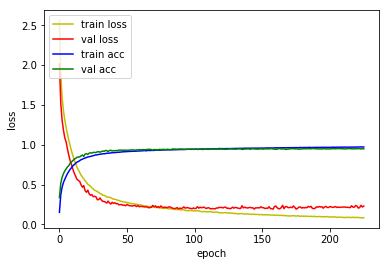

4815/4815 [==============================] - 2s 372us/sample - loss: 0.2330 - acc: 0.9373
Loss: 0.2330334084025301 Accuracy: 0.93727934

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5511 - acc: 0.1581
Epoch 00001: val_loss improved from inf to 1.98775, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_8_conv_checkpoint/001-1.9877.hdf5
36805/36805 [==============================] - 29s 796us/sample - loss: 2.5510 - acc: 0.1581 - val_loss: 1.9877 - val_acc: 0.3659
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8731 - acc: 0.3815
Epoch 00002: val_loss improved from 1.98775 to 1.40025, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_8_conv_checkpoint/002-1.4002.hdf5
36805/36805 [==============================] - 26s 700us/sample - loss: 1.8730 - acc: 0.3816 - val_loss: 1.4002 - val_acc: 0.5761
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4164 - acc: 0.8682
Epoch 00024: val_loss improved from 0.27188 to 0.27084, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_8_conv_checkpoint/024-0.2708.hdf5
36805/36805 [==============================] - 25s 692us/sample - loss: 0.4164 - acc: 0.8682 - val_loss: 0.2708 - val_acc: 0.9222
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4022 - acc: 0.8715
Epoch 00025: val_loss did not improve from 0.27084
36805/36805 [==============================] - 25s 686us/sample - loss: 0.4022 - acc: 0.8715 - val_loss: 0.2839 - val_acc: 0.9145
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3899 - acc: 0.8759
Epoch 00026: val_loss improved from 0.27084 to 0.25191, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_8_conv_checkpoint/026-0.2519.hdf5
36805/36805 [==============================] - 25s 691us/sample - loss: 0.3899 - acc: 0.8759 - val_loss: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.2485 - acc: 0.9202
Epoch 00049: val_loss improved from 0.17579 to 0.17262, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_8_conv_checkpoint/049-0.1726.hdf5
36805/36805 [==============================] - 25s 693us/sample - loss: 0.2485 - acc: 0.9202 - val_loss: 0.1726 - val_acc: 0.9509
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2413 - acc: 0.9210
Epoch 00050: val_loss improved from 0.17262 to 0.16472, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_8_conv_checkpoint/050-0.1647.hdf5
36805/36805 [==============================] - 26s 696us/sample - loss: 0.2413 - acc: 0.9210 - val_loss: 0.1647 - val_acc: 0.9539
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2334 - acc: 0.9255
Epoch 00051: val_loss did not improve from 0.16472
36805/36805 [==============================] - 25s 692us/sample - loss: 0.2333 - acc: 0.9255 - val_loss: 0.1859 - val_a

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1735 - acc: 0.9423
Epoch 00076: val_loss did not improve from 0.14257
36805/36805 [==============================] - 25s 688us/sample - loss: 0.1735 - acc: 0.9423 - val_loss: 0.1500 - val_acc: 0.9567
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1712 - acc: 0.9435
Epoch 00077: val_loss did not improve from 0.14257
36805/36805 [==============================] - 26s 695us/sample - loss: 0.1712 - acc: 0.9435 - val_loss: 0.1472 - val_acc: 0.9585
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1665 - acc: 0.9464
Epoch 00078: val_loss did not improve from 0.14257
36805/36805 [==============================] - 26s 694us/sample - loss: 0.1665 - acc: 0.9464 - val_loss: 0.1431 - val_acc: 0.9564
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1646 - acc: 0.9461
Epoch 00079: val_loss did not improve from 0.14257
36805/36805 [=====

Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1357 - acc: 0.9539
Epoch 00105: val_loss did not improve from 0.13715
36805/36805 [==============================] - 26s 693us/sample - loss: 0.1357 - acc: 0.9539 - val_loss: 0.1398 - val_acc: 0.9609
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1242 - acc: 0.9577
Epoch 00106: val_loss did not improve from 0.13715
36805/36805 [==============================] - 25s 692us/sample - loss: 0.1242 - acc: 0.9577 - val_loss: 0.1444 - val_acc: 0.9592
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1218 - acc: 0.9586
Epoch 00107: val_loss did not improve from 0.13715
36805/36805 [==============================] - 25s 689us/sample - loss: 0.1218 - acc: 0.9586 - val_loss: 0.1393 - val_acc: 0.9590
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1253 - acc: 0.9584
Epoch 00108: val_loss improved from 0.13715 to 0.13528, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 0.1005 - acc: 0.9643
Epoch 00134: val_loss did not improve from 0.13528
36805/36805 [==============================] - 25s 687us/sample - loss: 0.1005 - acc: 0.9644 - val_loss: 0.1514 - val_acc: 0.9585
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1018 - acc: 0.9649
Epoch 00135: val_loss did not improve from 0.13528
36805/36805 [==============================] - 26s 697us/sample - loss: 0.1018 - acc: 0.9649 - val_loss: 0.1544 - val_acc: 0.9595
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9661
Epoch 00136: val_loss did not improve from 0.13528
36805/36805 [==============================] - 25s 691us/sample - loss: 0.0973 - acc: 0.9661 - val_loss: 0.1449 - val_acc: 0.9644
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1000 - acc: 0.9654
Epoch 00137: val_loss did not improve from 0.13528
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9714
Epoch 00163: val_loss did not improve from 0.13419
36805/36805 [==============================] - 25s 692us/sample - loss: 0.0850 - acc: 0.9714 - val_loss: 0.1729 - val_acc: 0.9571
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0890 - acc: 0.9699
Epoch 00164: val_loss did not improve from 0.13419
36805/36805 [==============================] - 25s 689us/sample - loss: 0.0890 - acc: 0.9699 - val_loss: 0.1449 - val_acc: 0.9632
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9713
Epoch 00165: val_loss did not improve from 0.13419
36805/36805 [==============================] - 25s 689us/sample - loss: 0.0841 - acc: 0.9713 - val_loss: 0.1510 - val_acc: 0.9611
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0809 - acc: 0.9715
Epoch 00166: val_loss did not improve from 0.13419
36805/36805 [===============

Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0675 - acc: 0.9763
Epoch 00193: val_loss did not improve from 0.13419
36805/36805 [==============================] - 25s 692us/sample - loss: 0.0675 - acc: 0.9763 - val_loss: 0.1624 - val_acc: 0.9595
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0679 - acc: 0.9760
Epoch 00194: val_loss did not improve from 0.13419
36805/36805 [==============================] - 25s 691us/sample - loss: 0.0679 - acc: 0.9760 - val_loss: 0.1613 - val_acc: 0.9613
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9767
Epoch 00195: val_loss did not improve from 0.13419
36805/36805 [==============================] - 26s 703us/sample - loss: 0.0670 - acc: 0.9767 - val_loss: 0.1657 - val_acc: 0.9609
Epoch 196/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0660 - acc: 0.9773
Epoch 00196: val_loss did not improve from 0.13419
36805/36805 [=

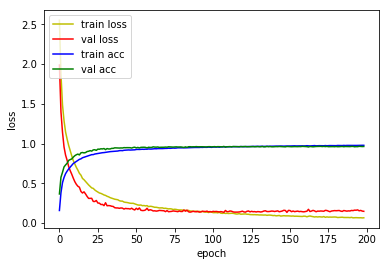

4815/4815 [==============================] - 2s 395us/sample - loss: 0.1897 - acc: 0.9477
Loss: 0.18966707489603157 Accuracy: 0.94766355

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4064 - acc: 0.2193
Epoch 00001: val_loss improved from inf to 1.60643, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_9_conv_checkpoint/001-1.6064.hdf5
36805/36805 [==============================] - 31s 847us/sample - loss: 2.4062 - acc: 0.2193 - val_loss: 1.6064 - val_acc: 0.5188
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4865 - acc: 0.5120
Epoch 00002: val_loss improved from 1.60643 to 1.06528, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_9_conv_checkpoint/002-1.0653.hdf5
36805/36805 [==============================] - 26s 715us/sample - loss: 1.4864 - acc: 0.5121 - val_loss: 1.0653 - val_acc: 0.6576
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3008 - acc: 0.9018
Epoch 00023: val_loss did not improve from 0.21376
36805/36805 [==============================] - 26s 712us/sample - loss: 0.3008 - acc: 0.9018 - val_loss: 0.2251 - val_acc: 0.9278
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2908 - acc: 0.9063
Epoch 00024: val_loss improved from 0.21376 to 0.20566, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_9_conv_checkpoint/024-0.2057.hdf5
36805/36805 [==============================] - 26s 714us/sample - loss: 0.2908 - acc: 0.9063 - val_loss: 0.2057 - val_acc: 0.9350
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2828 - acc: 0.9091
Epoch 00025: val_loss did not improve from 0.20566
36805/36805 [==============================] - 26s 719us/sample - loss: 0.2828 - acc: 0.9091 - val_loss: 0.2057 - val_acc: 0.9357
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.1516 - acc: 0.9490
Epoch 00049: val_loss improved from 0.15125 to 0.15035, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_9_conv_checkpoint/049-0.1503.hdf5
36805/36805 [==============================] - 27s 723us/sample - loss: 0.1516 - acc: 0.9490 - val_loss: 0.1503 - val_acc: 0.9529
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1457 - acc: 0.9515
Epoch 00050: val_loss did not improve from 0.15035
36805/36805 [==============================] - 26s 714us/sample - loss: 0.1458 - acc: 0.9515 - val_loss: 0.1581 - val_acc: 0.9502
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1504 - acc: 0.9500
Epoch 00051: val_loss did not improve from 0.15035
36805/36805 [==============================] - 26s 712us/sample - loss: 0.1504 - acc: 0.9500 - val_loss: 0.1617 - val_acc: 0.9522
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1406 -

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0894 - acc: 0.9698
Epoch 00078: val_loss did not improve from 0.14282
36805/36805 [==============================] - 26s 714us/sample - loss: 0.0894 - acc: 0.9698 - val_loss: 0.1501 - val_acc: 0.9583
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0873 - acc: 0.9700
Epoch 00079: val_loss did not improve from 0.14282
36805/36805 [==============================] - 27s 720us/sample - loss: 0.0873 - acc: 0.9700 - val_loss: 0.1755 - val_acc: 0.9527
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0850 - acc: 0.9709
Epoch 00080: val_loss did not improve from 0.14282
36805/36805 [==============================] - 26s 715us/sample - loss: 0.0850 - acc: 0.9709 - val_loss: 0.1482 - val_acc: 0.9571
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0851 - acc: 0.9706
Epoch 00081: val_loss did not improve from 0.14282
36805/36805 [=====

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0579 - acc: 0.9803
Epoch 00108: val_loss did not improve from 0.14282
36805/36805 [==============================] - 26s 717us/sample - loss: 0.0579 - acc: 0.9803 - val_loss: 0.1764 - val_acc: 0.9597
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0550 - acc: 0.9808
Epoch 00109: val_loss did not improve from 0.14282
36805/36805 [==============================] - 26s 715us/sample - loss: 0.0550 - acc: 0.9808 - val_loss: 0.1728 - val_acc: 0.9599
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9809
Epoch 00110: val_loss did not improve from 0.14282
36805/36805 [==============================] - 27s 721us/sample - loss: 0.0543 - acc: 0.9809 - val_loss: 0.1642 - val_acc: 0.9627

1D_CNN_custom_ch_32_DO_9_conv Model


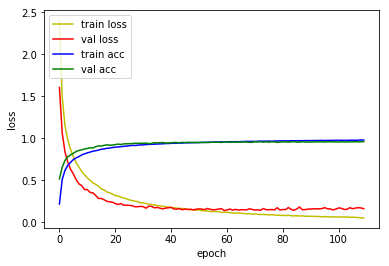

4815/4815 [==============================] - 2s 415us/sample - loss: 0.2135 - acc: 0.9379
Loss: 0.21350653049761384 Accuracy: 0.9379024



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_32_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_32_DO'
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_ch_32_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_44 (Activation)   (None, 533

4815/4815 [==============================] - 2s 433us/sample - loss: 0.4329 - acc: 0.8893
Loss: 0.4329061113166413 Accuracy: 0.8893043

1D_CNN_custom_ch_32_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 

4815/4815 [==============================] - 2s 471us/sample - loss: 0.2135 - acc: 0.9379
Loss: 0.21350653049761384 Accuracy: 0.9379024
